# XY-calibration (QSO)

In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from functools import reduce
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
Elg = 1.0049 #2023 FTS #0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg =  1.0240 #2023 FTS #1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09245 ''/inc and Ce is 0.01024 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "F4"
previous_xy_mapping = "Calibration/Mappings/2023/XY/F4_XY_230615_seemsok.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-0-F4_230820_good.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")

In [4]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)
#changer de centre 
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.1038940*u.deg, 1.594590*u.deg), rotation=(90-100)*u.deg, gamma=1)#QSO1
		
	
# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# ra, dec, rot = 36.9049,	0.65245,	0
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)


# # if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# # G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
# #                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
# #                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     raise ValueError("Please verify the initialization mapping")
star_target_path = "Calibration/Targets/2022/GuidingStars/%s_guidingstars.csv"%(Field)
F1_stars = Table.read(star_target_path).to_pandas()

stars =  [5,25,36,38] #QSOV 1
selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))




FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.18345483, -0.00024828)>
FOV center pixel position in guider [array(1361.74669352), array(540.18238164)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-160.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (253.0624, 34.9699)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV

/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_20886/2606816834.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_20886/2606816834.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_20886/2606816834.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1

## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# f_ra, f_dec, f_rot = 0.038940, 1.394590, 90-100
# f_ra, f_dec, f_rot = 14.62883, 0.00512, 90-100
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 


## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
# diffuse_offset = np.array([0.6,1.4])
diffuse_offset = np.array([])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

In [12]:
selected_stars, selected_slits

(<Table length=4>
 Internal count     RA      DEC    ...      Xguider             Yguider      
     int64       float64  float64  ...      float64             float64      
 -------------- --------- -------- ... ------------------ -------------------
              5 36.769798  0.65967 ... 1412.0026986195867  1135.6297103231918
             25  36.97544 0.590984 ... 1135.1559804711615  325.54740440082077
             36  37.03933 0.674384 ...  1463.590349488569  62.177013254173445
             38 37.049781 0.317274 ... 22.087757071207974 -1.8711405341363978,
 <Table length=0>
 Internal-count   x_mm    y_mm     RA     DEC  
    float64     float64 float64 float64 float64
 -------------- ------- ------- ------- -------)

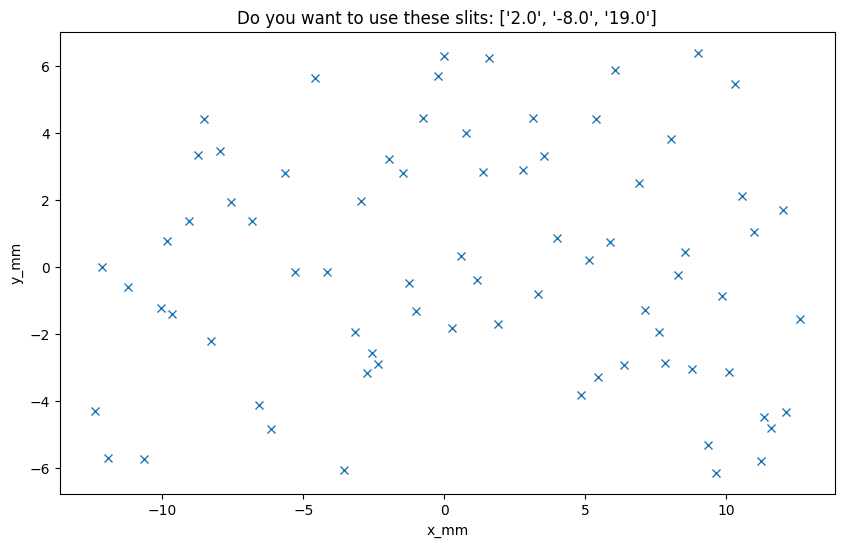

KeyError: 'GAIA gband'

In [11]:
slits = ['OVI14', '36', '4', 'QSO1', 'LyC7', '11',"7"] #F4
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.ylabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
# slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
# slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

# slit_path["ra_diff"] *= 3600
# slit_path["dec_diff"] *= 3600
# slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path
stars =  [29, 34, 18, 14 ]
selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

stars_and_slits = vstack([selected_stars["RA","DEC"],selected_slits["RA","DEC"]])

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


IndexError: index 0 is out of bounds for axis 0 with size 0

The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")
# ax1.plot(-46*selected_slits["x_mm"],46*selected_slits["y_mm"],"o")
# ax1.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")


In [10]:

slits_coord_obs_det = np.array([
[  1691,	1840  ],
[  1881,	457  ],
[  1587,	1350  ],
[  1777,	691   ],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.20803784, 0.19506611)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.27644385, -0.22303151)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.17482672, 0.04695024)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.2412545, -0.15232547)]>]

### look at siderostat frame hysteresis 

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation and translation
theta: -31.3 arcmin
dx: -3.1 arcsec
dy: 155.4 arcsec
variances: [2.7762065  0.50051175 0.82186866]

residuals in arcsec: [[  0.9689951  -13.37782897]
 [ -3.04922314  11.80404767]
 [  2.99211969  -5.30505897]
 [ -0.91189164   6.87884028]]
max residual in EL,CE 3.0, 13.4 arcsec
mean residual in EL,CE 2.2, 9.9 arcsec
After updating:
    mask_rotation: -31.303559852076287 arcmin
    FOV center in guider: 1391.8464377509965 x 605.3093719405705 pix = 688.3487457501031 arcsec x 59.4945237517903 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ 0.01600173 -0.06658658 -0.14847223  0.21048168  0.27228581  0.17393306
  0.23776267] [-0.10426039  0.05092138  0.13113951  0.28179802 -0.14513307  0.13162056
 -0.07230179]
[ 0.01600173 -0.06658658 -0.14847223  0.21048168  0.27228581  0.17393306
  0.23776267] [-0.10426039  0.05092138  0.13113951  0.28179802 -0.14513307  0.13162056
 -0.07230179]


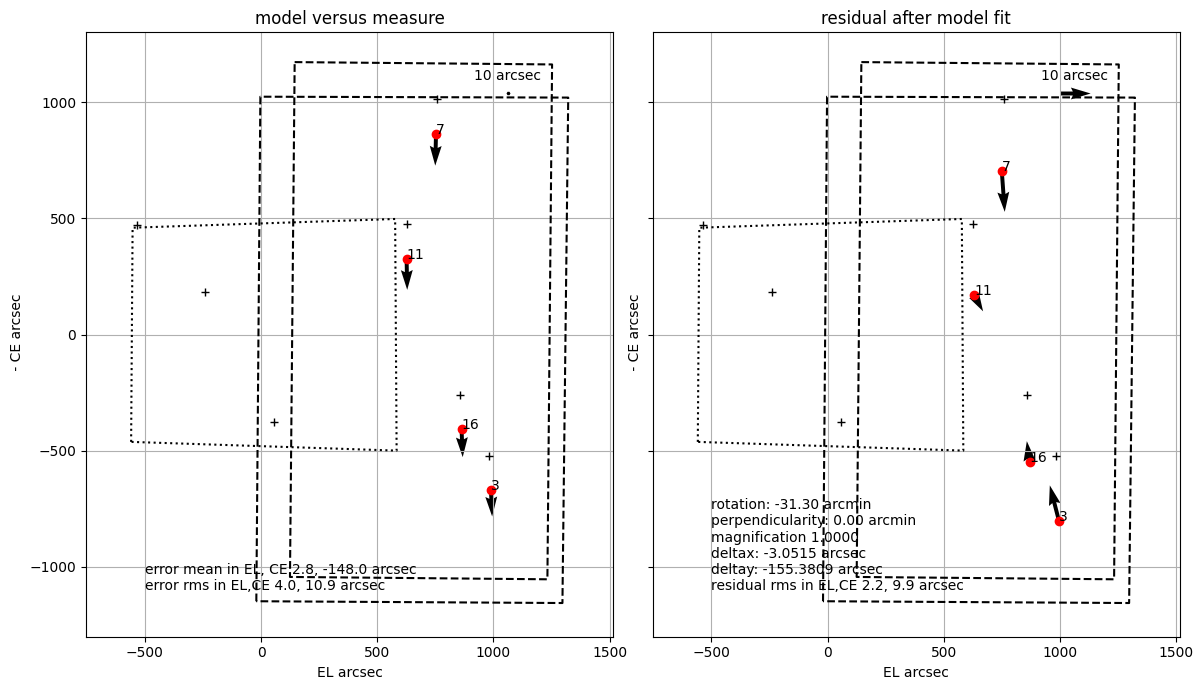


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [11]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits,gamma=False,selected_stars=stars_and_slits)


### check updating with fitting magnification


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (14.62883, 0.00512)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: -31.303559852076287 arcmin
    FOV center in guider: 1391.8464377509965x605.3093719405705 pix

Fitting rotation, translation and magnification
gamma: 1.016 
theta: -31.3 arcmin
dx: -16.3 arcsec
dy: 154.9 arcsec
variances: [8.07565734e-04 2.77620650e+00 8.22180087e-01 8.22180087e-01]

residuals in arcsec: 

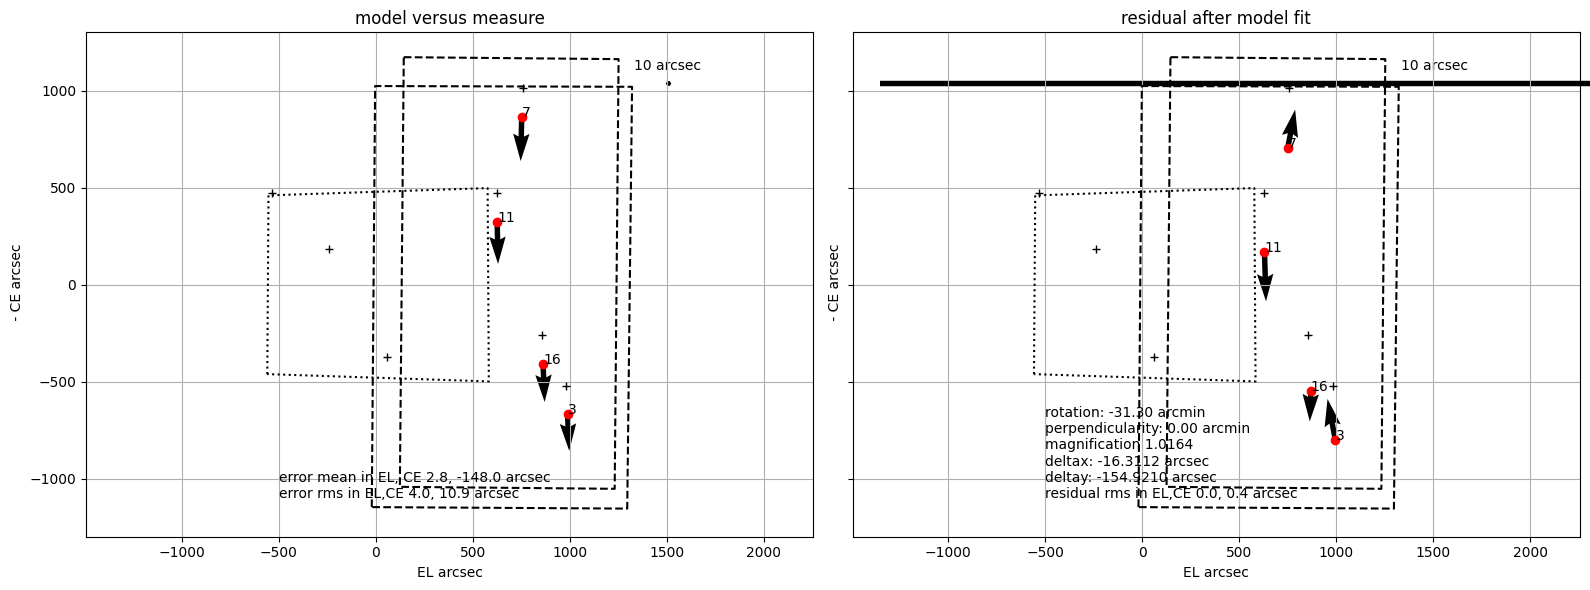


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [12]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False,selected_stars=stars_and_slits)


### Verify what magnification it predicts
### save corrected model for future use (eg redo the calib on same field)

# Another try in open mask

In [13]:
# slits =[  '7',"3","11","14"]# short pass
# selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

# selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves


slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 376.4 arcsec ; CE: -492.9 arcsec
EL: 486.9 arcsec ; CE: 254.1 arcsec
EL: 311.1 arcsec ; CE: -230.6 arcsec
EL: 425.3 arcsec ; CE: 126.7 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,376.429370,-492.926524,True,376.429370,-492.926524
1,110.489293,747.000192,True,486.918663,254.073669
2,-175.787906,-484.643253,True,311.130757,-230.569584
3,114.139932,357.224183,True,425.270689,126.654599


wave:  0.20619
Fitting rotation and translation
theta: -2.5 arcmin
dx: 0.6 arcsec
dy: 2.3 arcsec
variances: [2.77609141 0.51981744 0.8200562 ]

residuals in arcsec: [[  1.04063626 -16.50516104]
 [ -3.4005654   12.75359277]
 [  3.00075854  -5.27673041]
 [ -0.64082941   9.02829868]]
max residual in EL,CE 3.4, 16.5 arcsec
mean residual in EL,CE 2.3, 11.7 arcsec
After updating:
    mask_rotation: -33.81195915811896 arcmin
    FOV center in guider: 1392.577979833612 x 607.221906010164 pix = 689.0234547376728 arcsec x 61.27083810248449 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ 0.01609986 -0.06637578 -0.14820345  0.21086277  0.27235582  0.17420434
  0.23788559] [-0.10363994  0.05160312  0.13188152  0.28227915 -0.14469988  0.13212735
 -0.07184293]
[ 0.01609986 -0.06637578 -0.14820345  0.21086277  0.27235582  0.17420434
  0.23788559] [-0.10363994  0.05160312  0.13188152  0.28227915 -0.14469988  0.13212735
 -0.07184293]


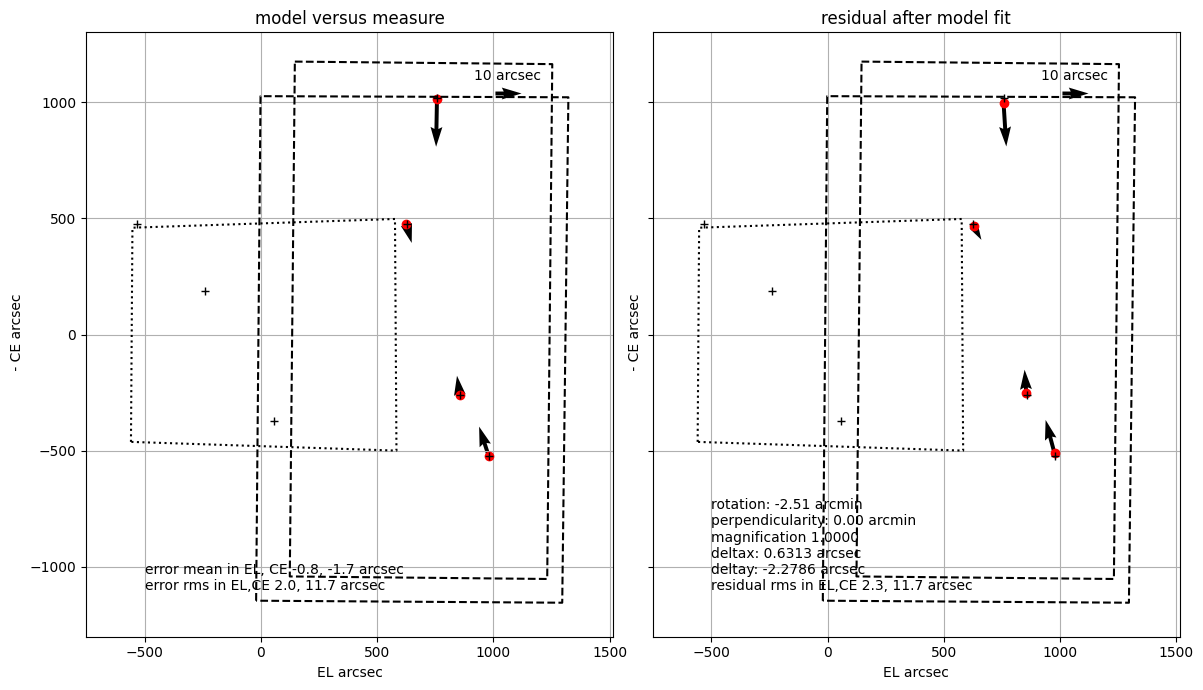


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [14]:
slits_coord_obs_det = np.array([
[   1697,	1972   ],
[   1872,	591  ],
[   1588,	1486  ],
[   1771,	827  ]])



valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7),gamma=False,selected_stars=stars_and_slits)#, labels=slits)#



In [15]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/%s_XY_gamma%0.2f_%s.pkl"%(Field, G2UVcor.FieldP.gamma, datetime.datetime.now().strftime("%y%m%d")))


Dumping to Calibration/Mappings/2023/XY/QSO_XY_gamma1.00_230822.pkl


In [16]:
# slits =[  '7',"3","11","14"]# short pass
# selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

# # selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

# moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
# moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# # assert moves.sum(axis=0)[0] <0.1
# # assert moves.sum(axis=0)[1] <0.1
# moves["UV_image"] = moves["UV_image"].astype(bool)
# moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
# moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# # slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# # slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# # slit_path
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# try:
#     moves.to_clipboard()
# except Exception as e:
#     print("Could not copy: ", e)
# moves


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [17]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

# new_cat = slit_path[:-1]
# new_cat["EL"] = moves["EL"][1:]
# new_cat["CE"] = moves["CE"][1:]

# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# # new_cat.to_pandas().to_clipboard()



# plt.figure()
# plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
# plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
# plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
# plt.legend()
# plt.show()
# new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 377.1 arcsec ; CE: -493.8 arcsec
EL: 487.0 arcsec ; CE: 253.3 arcsec
EL: 311.6 arcsec ; CE: -231.5 arcsec
EL: 425.5 arcsec ; CE: 125.9 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


EL,CE,UV_image,EL_abs,CE_abs
float64,float64,float64,float64,float64
377.1103838621102,-493.7696504197787,1.0,377.1103838621102,-493.7696504197787
109.93369364630156,747.0841283566295,1.0,487.04407750841176,253.31447793685084
-175.42813295434487,-484.7721183752396,1.0,311.6159445540669,-231.45764043838875
113.87464571974553,357.3081387047541,1.0,425.4905902738125,125.85049826636538


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

# here we should not rerun the model because we tronc the fiber so we actually do not get the real center

In [18]:
# slits_coord_obs_det = np.array([
# [ 435.4,	1964.8],
# [ 597.6,	1856.9],
# [ 744.2,	459.3],
# [ 479.6,	1370.5],
# ]) 


# valid = np.isfinite(slits_coord_obs_det[:,0])
# obs_wave =  0.20619
# print("wave: ", obs_wave)
# slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# # slits_valid = slits[valid]
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# slits_coord_obs
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
# G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),gamma=False)#, labels=slits_valid


# moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
# moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
# moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# try:
#     moves.to_pandas().to_clipboard()
# except Exception as e:
#     print("Could not copy: ", e)
# moves

# new_cat = slit_path[:-1]
# new_cat["EL"] = moves["EL"][1:]
# new_cat["CE"] = moves["CE"][1:]

# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# # new_cat.to_pandas().to_clipboard()



# plt.figure()
# plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
# plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
# plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
# plt.legend()
# plt.show()
# new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"



In [16]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field3.pkl")

Dumping to Calibration/Mappings/2022/XY/QSO1_XY_230621_Field3.pkl


# Again another iteration in open mask? NO

In [17]:
# slits_coord_obs_det = np.array([
# [ 670.6,	221.5 ],
# [ 364.6,	1672.1],
# [ 640.9,	704.2 ],
# [ 594.8,	1854  ],
# [ 515.8,	167.7 ],
# # [ 1738.5	,1903.5  ],
# # [ 1592.6	,1205.5  ],
# # [ 1569.6	,1765.5  ],
# # [ 1788.5,	732.5  ]
# ]) 


# valid = np.isfinite(slits_coord_obs_det[:,0])
# obs_wave =  0.20619
# print("wave: ", obs_wave)
# slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# # slits_valid = slits[valid]
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# slits_coord_obs
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
# G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7))#, labels=slits_valid


# moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
# moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
# moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# try:
#     moves.to_pandas().to_clipboard()
# except Exception as e:
#     print("Could not copy: ", e)
# moves

# new_cat = slit_path[:-1]
# new_cat["EL"] = moves["EL"][1:]
# new_cat["CE"] = moves["CE"][1:]

# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# # new_cat.to_pandas().to_clipboard()



# plt.figure()
# plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
# plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
# plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
# plt.legend()
# plt.show()
# new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"




## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence We begin by QSO 5
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

In [20]:
# il faut que le centre soit bien defini à l'arcseconde pres.
# stars = [2, 4, 5, 6, 7]
# stars =  [13,14]#[2, 4, 5, 6, 7]
# selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves





targets local coords in siderostat local frame:
EL: 28.8 arcsec ; CE: 181.6 arcsec
EL: -118.7 arcsec ; CE: -90.4 arcsec
EL: -265.1 arcsec ; CE: -231.1 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,28.798319,181.612053,1.0
1,-147.526728,-272.038084,1.0
2,-146.367688,-140.674766,1.0


In [21]:
stars_path = vstack((selected_stars,selected_stars[::-1]) )
selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
print("(They have been copied to clipboard, paste it in the spreadsheet)")
star_moves.to_clipboard()


(They have been copied to clipboard, paste it in the spreadsheet)


In [26]:
selected_stars

Internal count,RA,DEC,g mag,x deg,y deg,xmm_nicole,ymm_nciole
int64,float64,float64,float64,float64,float64,float64,float64
17,351.719117,-1.990274,10.760506,-0.134103,-0.13498,-5.661853,-5.698882
18,351.915116,-1.887787,10.212835,0.061782,-0.032488,2.61064,-1.372815
19,351.917335,-1.86546,9.717599,0.064001,-0.010161,2.704453,-0.42938
20,351.944342,-1.952026,9.897263,0.09099,-0.096728,3.843519,-4.085917
21,351.947933,-2.004666,11.121481,0.094576,-0.149369,3.993547,-6.307


Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl

targets local coords in siderostat local frame:
EL: 103.3 arcsec ; CE: -267.1 arcsec
EL: 283.2 arcsec ; CE: 77.9 arcsec
EL: 323.1 arcsec ; CE: 82.2 arcsec
EL: 167.7 arcsec ; CE: 128.0 arcsec
EL: 73.5 arcsec ; CE: 133.3 arcsec

siderostat moves sequence: 
RA=351.9, DEC=-1.9, rot=0
 stars =  
Internal count     RA        DEC      g mag     x deg  
-------------- ---------- --------- --------- ---------
            17 351.719117 -1.990274 10.760506 -0.134103
            18 351.915116 -1.887787 10.212835  0.061782
            19 351.917335  -1.86546  9.717599  0.064001
            20 351.944342 -1.952026  9.897263   0.09099
            21 351.947933 -2.004666 11.121481  0.094576
'numpy.float64' object is not iterable
[0.05773491 0.15829964 0.18060476 0.09377202 0.04109648] [ 0.15244932 -0.04444324 -0.04688145 -0.07301812 -0.07608629]
[0.05773491 0.15829964 0.18060476 0.09377202 0.04109648] [ 0.15244932 -0.04444324 -0.046881

/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:738: RuntimeWarning: Mean of empty slice.
  delta_mean = delta.mean(axis=0)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:739: RuntimeWarning: Mean of empty slice.
  delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0)) * 3600
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:771: RuntimeWarning: Mean of empty slice.
  residual_rms = np.sqrt(np.square(residuals).mean(axis=0)) * 3600
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


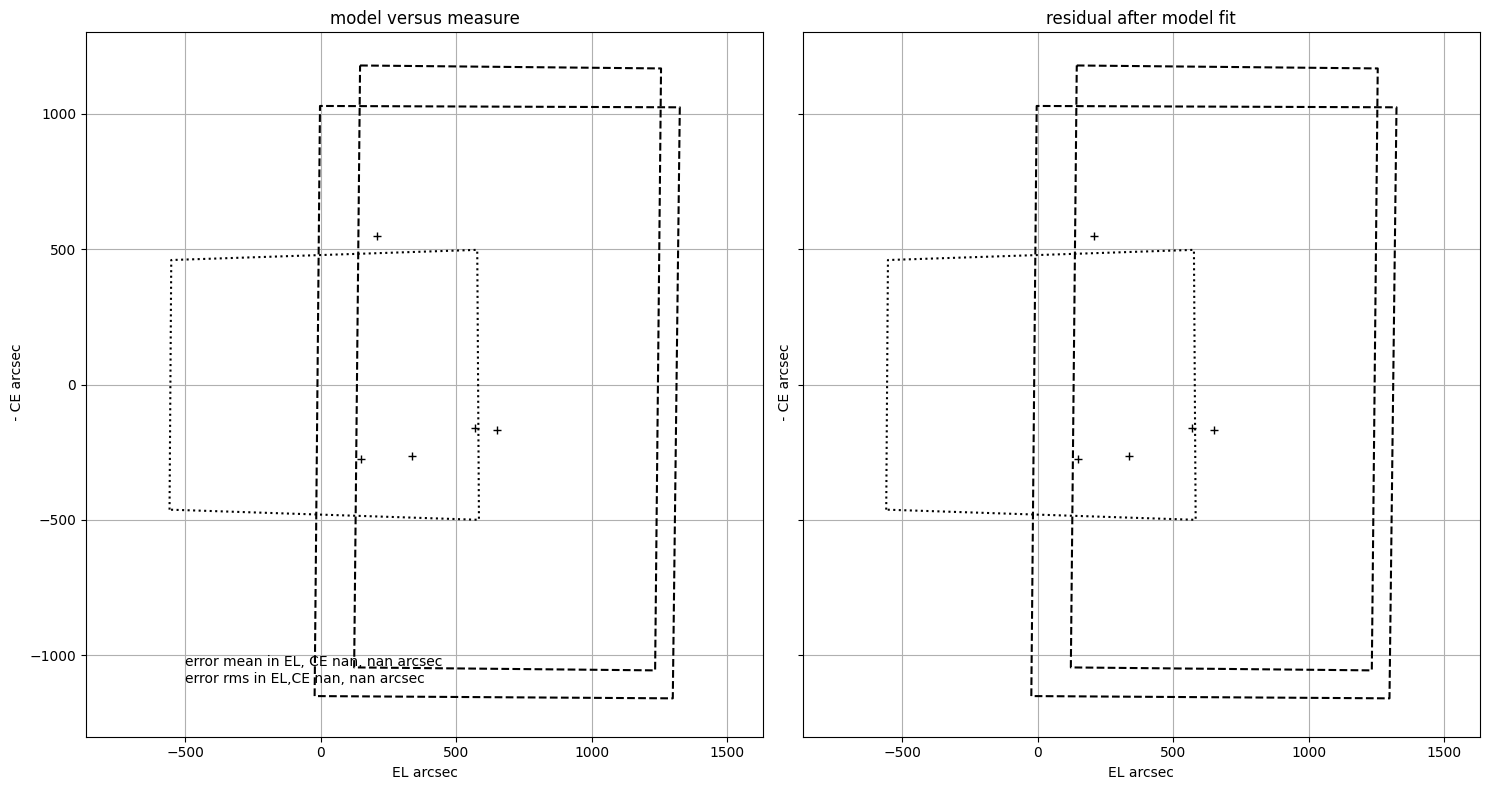

In [32]:



stars = [17, 18, 19, 20, 21] #QSOV 14
#back to guider center
ra, dec, rot = 351.8533, -1.8553, 0

G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)

selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves
print("RA=%0.1f, DEC=%0.1f, rot=%s\n stars =  \n%s"%(ra, dec, rot ,selected_stars[selected_stars.colnames[:5]]))
G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10, G2UVcor=None, selected_stars=selected_stars)


In [25]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 103.3 arcsec ; CE: -267.1 arcsec
EL: 283.2 arcsec ; CE: 77.9 arcsec
EL: 323.1 arcsec ; CE: 82.2 arcsec
EL: 167.7 arcsec ; CE: 128.0 arcsec
EL: 73.5 arcsec ; CE: 133.3 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field1.pkl

targets local coords in siderostat local frame:
EL: 5.7 arcsec ; CE: -45.6 arcsec
EL: 83.4 arcsec ; CE: -152.3 arcsec
EL: 94.9 arcsec ; CE: -139.6 arcsec
EL: 236.3 arcsec ; CE: -71.2 arcsec
EL: 157.5 arcsec ; CE: -64.3 arcsec

siderostat moves sequence: 
RA=0.0, DEC=1.4, rot=-10
 stars =  
Internal count     RA       DEC      g mag     x deg  
-------------- ---------- -------- --------- ---------
             2   0.064613 1.207946 11.823838 -0.007133
             4 359.996741 1.239476 11.899264 -0.068484
             5   0.002719 1.247124  11.21874  -0.06127
             6     0.0266 1.331968   9.07557 -0.023024
             7   0.038536 1.289373 10.086621 -0.018669
'numpy.float64' object is not iterable
[0.00320015 0.04663787 0.0530608  0.13209349 0.08803063] [0.02600432 0.08693342 0.0796556  0.0406286  0.03670662]
[0.00320015 0.04663787 0.0530608  0.13209349 0.08803063] [0.02600432 0.08693342 0.0796556  0.0406286  0.

/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:738: RuntimeWarning: Mean of empty slice.
  delta_mean = delta.mean(axis=0)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:739: RuntimeWarning: Mean of empty slice.
  delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0)) * 3600
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:771: RuntimeWarning: Mean of empty slice.
  residual_rms = np.sqrt(np.square(residuals).mean(axis=0)) * 3600
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


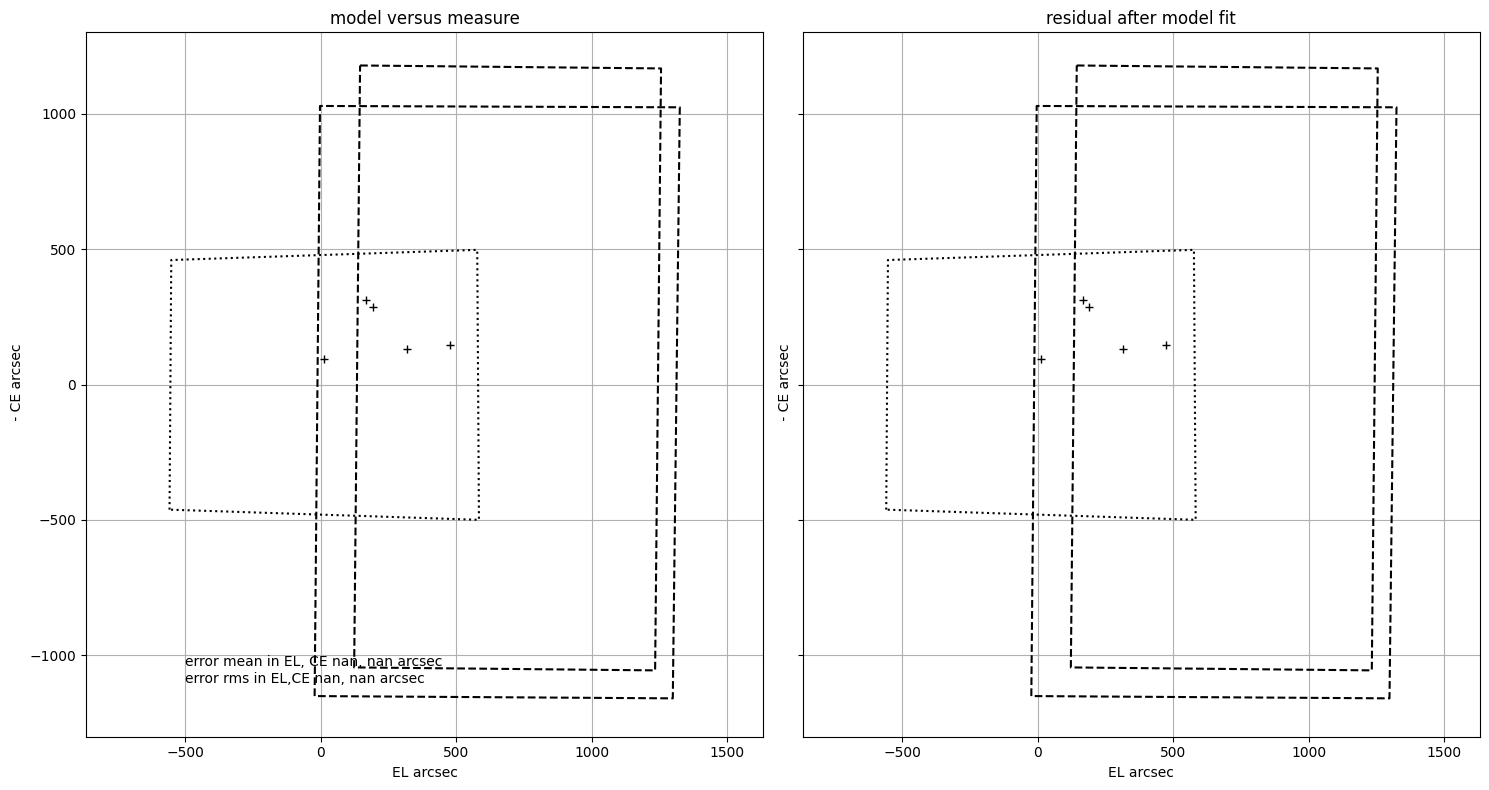

In [38]:
#back to guider center

stars =  [2, 4, 5, 6, 7] #QSOV 1
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))


ra, dec, rot =0.03894, 1.39459, (90-100)

G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)

G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field1.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
# selected_stars.to_pandas().to_clipboard()

print("RA=%0.1f, DEC=%0.1f, rot=%s\n stars =  \n%s"%(ra, dec, rot ,selected_stars[selected_stars.colnames[:5]]))
G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10, G2UVcor=None, selected_stars=selected_stars)



In [37]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 5.7 arcsec ; CE: -45.6 arcsec
EL: 83.4 arcsec ; CE: -152.3 arcsec
EL: 94.9 arcsec ; CE: -139.6 arcsec
EL: 236.3 arcsec ; CE: -71.2 arcsec
EL: 157.5 arcsec ; CE: -64.3 arcsec

siderostat moves sequence: 


In [41]:


stars = [8, 10, 12] #QSO7
#back to guider center
#Load new 
ra, dec, rot = 22.42638, 0.62279, 90-70
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
selected_stars.to_pandas().to_clipboard()
# G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field2.pkl")
print("RA=%0.1f, DEC=%0.1f, rot=%s\n stars =  \n%s"%(ra, dec, rot ,selected_stars[selected_stars.colnames[:5]]))

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363


RA=22.4, DEC=0.6, rot=20
 stars =  
Internal count     RA      DEC      g mag    x deg  
-------------- --------- -------- --------- --------
             8 22.374342 0.385839 11.857352 0.032143
            10 22.470774 0.374579   7.73287  0.12661
            12 22.455571 0.580502 10.246187 0.041892



targets local coords in siderostat local frame:
EL: -88.3 arcsec ; CE: 22.4 arcsec
EL: -49.9 arcsec ; CE: 188.3 arcsec
EL: 288.4 arcsec ; CE: 43.1 arcsec

siderostat moves sequence: 
'numpy.float64' object is not iterable
[-0.04937935 -0.02790874  0.16122912] [-0.01275838 -0.10744436 -0.02458016]
[-0.04937935 -0.02790874  0.16122912] [-0.01275838 -0.10744436 -0.02458016]


/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:738: RuntimeWarning: Mean of empty slice.
  delta_mean = delta.mean(axis=0)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:739: RuntimeWarning: Mean of empty slice.
  delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0)) * 3600
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:771: RuntimeWarning: Mean of empty slice.
  residual_rms = np.sqrt(np.square(residuals).mean(axis=0)) * 3600
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


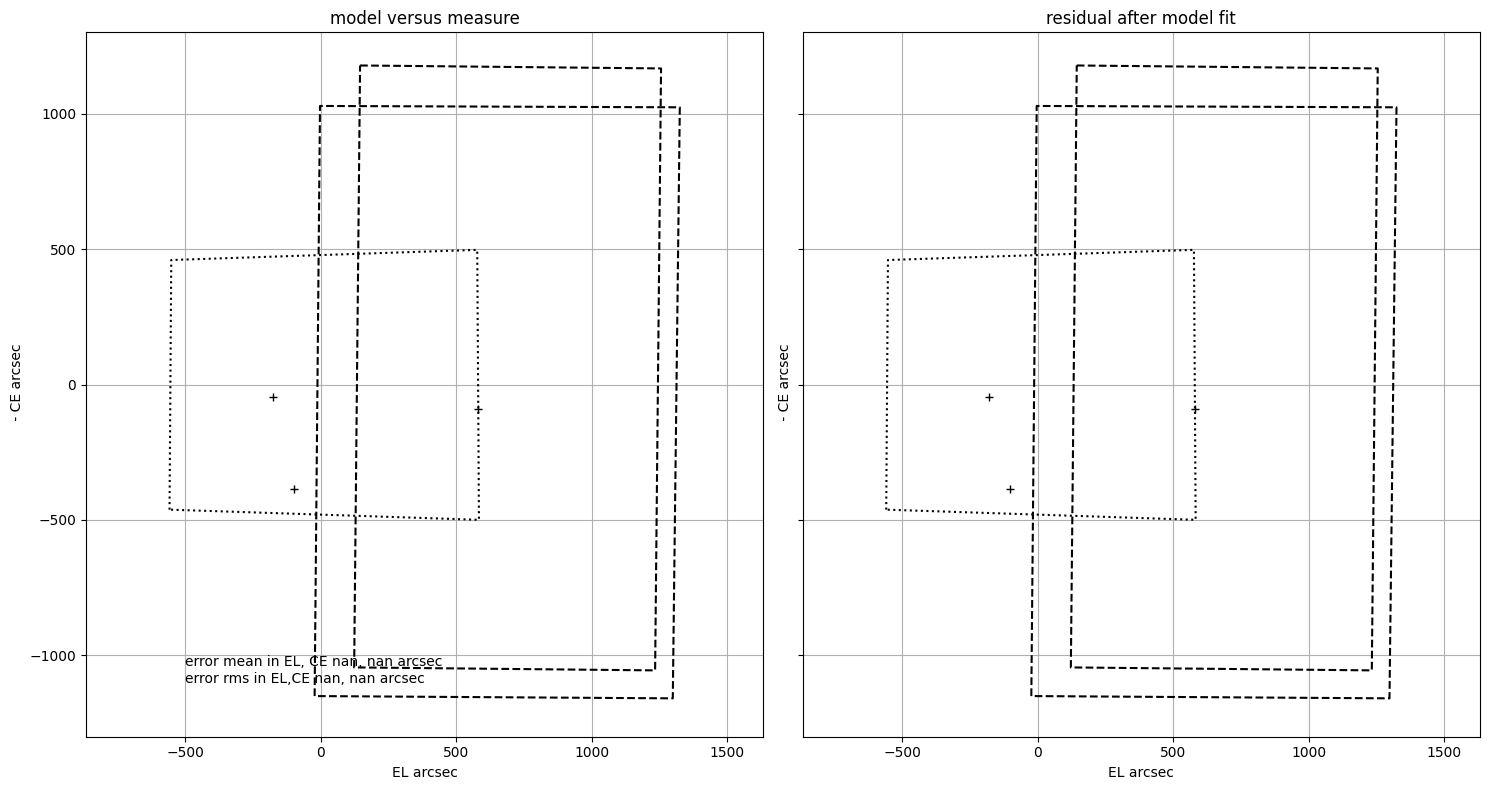

In [43]:

star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10, G2UVcor=None, selected_stars=selected_stars)


In [22]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
29,36.987137,0.402799,3.499382,-10.623502,10,--,--,375.60643978519715,274.037723163956
34,37.023638,0.390844,5.052622,-11.132199,9,--,--,329.09823563737774,119.62777354437654
18,36.877561,0.53311,-1.163312,-5.078307,--,12,11,905.7629054456784,724.3865249427333
14,36.867454,0.492628,-1.593376,-6.800959,--,13,12,743.471574722354,767.263365496059
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------